#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:150%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
    * [CONFIGURATION](#2.1)
    * [CONFIGURATION PARAMETERS](#2.2)    
    * [DATASET COLUMNS](#2.3)
* [PREPROCESSING](#3)
* [ADVERSARIAL CV](#4)
* [EDA AND VISUALS](#5) 
* [DATA TRANSFORMS](#6)
* [MODEL TRAINING](#7)      
* [PLANNED WAY FORWARD](#8)     

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > IMPORTS<br> <div> 

In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import clear_output;

! python -m pip install --no-index \
--find-links=/kaggle/input/packageinstallation \
-r /kaggle/input/packageinstallation/requirements.txt -q;
clear_output();

import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk;
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}");
print(f"---> Sklearn = {sk.__version__}\n\n")
collect();

---> XGBoost = 2.0.2 | LightGBM = 4.1.0 | Catboost = 1.2.2
---> Sklearn = 1.3.2


CPU times: user 3.35 s, sys: 692 ms, total: 4.04 s
Wall time: 22.7 s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;

print();
collect();
clear_output();

CPU times: user 191 ms, sys: 11.4 ms, total: 203 ms
Wall time: 237 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import log_loss,  make_scorer;
from xgboost import DMatrix, XGBClassifier as XGBC;
from lightgbm import log_evaluation, early_stopping, LGBMClassifier as LGBMC;
from catboost import CatBoostClassifier as CBC, Pool;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.ERROR;

clear_output();
print();
collect();


CPU times: user 478 ms, sys: 41.4 ms, total: 520 ms
Wall time: 587 ms


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();



CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 119 ms


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > INTRODUCTION<br><div> 

| Version<br>Number | Version Details | CV score| Single/ Ensemble|Public LB Score|
| :-: | --- | :-: | :-: |:-:|
| **V1** |* Risk factor addition <br> * Used categorical features <br> * 10 x1 RSKF CV Boosted tree models <br> * Mean ensemble|0.43777|Ensemble|0.40696|
| **V2** |* No secondary features <br> * Used categorical features <br> * 10 x1 RSKF CV Boosted tree models <br> * Mean ensemble|0.43741|Ensemble|0.40624|
| **V3** |* No secondary risk-factor features <br> * Used null imputation <br> * Used categorical features <br> * 10 x1 RSKF CV Boosted tree models <br> * Mean ensemble|0.43780|Ensemble|0.40666|
| **V4** |* No secondary risk-factor features <br> * Used null imputation <br> * Used categorical features <br> * 10 x1 RSKF CV Boosted tree models <br> * Excluded Catboost <br> * Mean ensemble||Ensemble||

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION<br><div> 

In [5]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 4;
    test_req           = "N";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = 'Status';
    episode            = 26;
    path               = f"/kaggle/input/playground-series-s3e{episode}";
    orig_path          = f"/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv";
    
    dtl_preproc_req    = "Y";
    adv_cv_req         = "N";
    ftre_plots_req     = 'Y';
    ftre_imp_req       = "Y";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    drop_nulls         = "N";
    sec_ftre_req       = "N";
    scale_req          = "N";
    # NOTE---Keep a value here even if scale_req = N, this is used for linear models:-
    scl_method         = "Z"; 
    enc_method         = 'Label';
    OH_cols            = [];
    tgt_mapper         = {"C": 0, "CL":1, "D":2};
    
    # Model Training:- 
    baseline_req       = "N";
    pstprcs_oof        = "N";
    pstprcs_train      = "N";
    pstprcs_test       = "N";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.90;
    pseudolbl_low      = 0.05;
    
    use_orig_allfolds  = "N";
    n_splits           = 10 ;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 50 ;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "N";
    hill_climb_req     = "N";
    optuna_req         = "N";
    LAD_req            = "N";
    enscv_mthd         = "RSKF";
    metric_obj         = 'minimize';
    ntrials            = 10 if test_req == "Y" else 500;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 129 ms, sys: 685 µs, total: 130 ms
Wall time: 129 ms


In [6]:
%%time 

# Defining functions to be used throughout the code for common tasks:-

# Scaler to be used for continuous columns:- 
all_scalers = {'Robust': RobustScaler(), 
               'Z': StandardScaler(), 
               'MinMax': MinMaxScaler(),
               "PT" : PowerTransformer(),
              };
scaler      = all_scalers.get(CFG.scl_method);

# Making a directory to store the model objects:-
if os.path.exists("/kaggle/working/MLModels") == True:
    PrintColor(f"\n---> MLModels already exists\n", color = Fore.RED);
else:
    os.mkdir("MLModels");
    PrintColor(f"\n---> Made directory MLModels to store models for inference\n", color = Fore.RED)


collect();
print();



---> Made directory MLModels to store models for inference


CPU times: user 139 ms, sys: 0 ns, total: 139 ms
Wall time: 138 ms


<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION PARAMETERS<br><div> 


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)/ int       |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  target           | Target column name                                      | yield                 |
|  episode          | Episode Number                                          | integer               |
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  adv_cv_req       | Adversarial CV required                                 | Y/N                   |
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |
|  scale_req        | Scaling required                                        | Y/N                   |
|  scl_method       | Scaling method                                          | Z/ Robust/ MinMax     |
|  enc_method       | Encoding method                                         |-                      |
|  OH_cols          | Onehot columns                                          |list                   |
|  drop_tr_req      | Drop extra training elements not in test                | Y/N                   |
|  baseline_req     | Baseline model required                                 | Y/N                   |
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

<a id="2.3"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > DATASET AND COMPETITION DETAILS<br><div>
    
**Data columns**<br>
This is available in the original data description as below<br>
https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction/ <br>
<br>**Competition details and notebook objectives**<br>
1. This is a multi-class classification challenge to predict liver cirrhosis. **Multi-logloss** is the metric for the challenge<br>
2. In this starter notebook, we start the assignment with a detailed EDA, feature plots, interaction effects, adversarial CV analysis and develop starter models to initiate the challenge. We will also incorporate other opinions and approaches as we move along the challenge.<br>
<br>
**Model strategy** <br>
We start off with simple tree based ML models and a mean ensemble to create sample inputs for the submission. <br>


<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > PREPROCESSING<br><div> 

In [7]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.target            = CFG.target ;
        self.original          = pd.read_csv(CFG.orig_path);
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original = {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\s+","", regex = True);
            
        PrintColor(f"\nTrain set head", color = Fore.GREEN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.GREEN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.GREEN);
        display(self.original.head(5).style.format(precision = 3));
                 
        # Resetting original data index:-
        self.original.index = range(len(self.original));
        self.original.index+= max(self.test.index) + 1;
        self.original.index.name = 'id';
        
        #  Changing original data column order to match the competition column structure:-
        self.original = self.original.reindex(self.train.columns, axis=1);
              
    def _AddSourceCol(self):
        self.train['Source'] = "Competition";
        self.test['Source']  = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([CFG.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        
        return self; 
        
    def ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"Train shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");
            
            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");
            
            train.index = range(len(train));
            train.index.name = 'id';
        
        else:
            PrintColor(f"We are using the competition training data only");
            train = self.train;
        return train;
          
collect();
print();

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.91 µs



In [8]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

print();
collect();

Data shapes - train-test-original = (7905, 19) (5271, 18) (418, 20)

Train set head


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.300,316.000,3.350,172.000,1601.000,179.800,63.000,394.000,9.700,3.000,D
1,2574,Placebo,19237,F,N,N,N,N,0.900,364.000,3.540,63.000,1440.000,134.850,88.000,361.000,11.000,3.000,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.300,299.000,3.550,131.000,1029.000,119.350,50.000,199.000,11.700,4.000,D
3,2576,Placebo,18460,F,N,N,N,N,0.600,256.000,3.500,58.000,1653.000,71.300,96.000,269.000,10.700,3.000,C
4,788,Placebo,16658,F,N,Y,N,N,1.100,346.000,3.650,63.000,1181.000,125.550,96.000,298.000,10.600,4.000,C



Test set head


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
id,,,,,,,,,,,,,,,,,,
7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.200,546.000,3.370,65.000,1636.000,151.900,90.000,430.000,10.600,2.000
7906,2468,D-penicillamine,14975,F,N,N,N,N,1.100,660.000,4.220,94.000,1257.000,151.900,155.000,227.000,10.000,2.000
7907,51,Placebo,13149,F,N,Y,N,Y,2.000,151.000,2.960,46.000,961.000,69.750,101.000,213.000,13.000,4.000
7908,2330,D-penicillamine,20510,F,N,N,N,N,0.600,293.000,3.850,40.000,554.000,125.550,56.000,270.000,10.600,2.000
7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.400,277.000,2.970,121.000,1110.000,125.000,126.000,221.000,9.800,1.000



Original set head


,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.500,261.000,2.600,156.000,1718.000,137.950,172.000,190.000,12.200,4.000
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.100,302.000,4.140,54.000,7394.800,113.520,88.000,221.000,10.600,3.000
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.400,176.000,3.480,210.000,516.000,96.100,55.000,151.000,12.000,4.000
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.800,244.000,2.540,64.000,6121.800,60.630,92.000,183.000,10.300,4.000
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.400,279.000,3.530,143.000,671.000,113.150,72.000,136.000,10.900,3.000



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
N_Days,"2,030.17","1,094.23",41.00,334.00,"1,230.00","1,831.00","2,689.00","3,672.00","4,127.00","4,509.00","4,795.00"
Age,"18,373.15","3,679.96","9,598.00","12,307.00","15,574.00","18,713.00","20,684.00","22,960.00","24,622.00","27,220.00","28,650.00"
Bilirubin,2.59,3.81,0.30,0.50,0.70,1.10,3.00,6.40,11.00,20.00,28.00
Cholesterol,350.56,195.38,120.00,198.00,248.00,298.00,390.00,514.00,646.00,"1,276.00","1,775.00"
Albumin,3.55,0.35,1.96,2.97,3.35,3.58,3.77,3.95,4.08,4.30,4.64
Copper,83.90,75.90,4.00,14.00,39.00,63.00,102.00,172.00,231.00,412.00,588.00
Alk_Phos,"1,816.75","1,903.75",289.00,614.00,834.00,"1,181.00","1,857.00","3,472.00","6,064.80","11,036.55","13,862.40"
SGOT,114.60,48.79,26.35,54.25,75.95,108.50,137.95,173.60,198.40,272.29,457.25
Tryglicerides,115.34,52.53,33.00,56.00,84.00,104.00,139.00,175.00,210.00,309.00,598.00
Platelets,265.23,87.47,62.00,128.00,211.00,265.00,316.00,375.00,430.00,493.00,563.00



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   float64
 15  Platelets      7905 non-null   float64
 16  Prothrombin    7905 non-null   float64
 17  Stage          7905 non-null   float6

None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
N_Days,"2,038.70","1,086.84",41.00,334.00,"1,234.00","1,882.00","2,692.00","3,611.00","4,184.00","4,509.00","4,795.00"
Age,"18,497.76","3,583.90","9,598.00","12,307.00","15,730.00","18,806.00","20,684.00","22,873.00","24,472.00","27,220.00","28,650.00"
Bilirubin,2.60,3.85,0.30,0.50,0.70,1.10,3.00,6.40,9.95,20.00,28.00
Cholesterol,352.49,200.44,120.00,201.00,248.00,299.00,390.00,516.00,652.00,"1,336.00","1,775.00"
Albumin,3.54,0.35,1.96,2.94,3.35,3.57,3.77,3.95,4.09,4.30,4.64
Copper,84.70,77.54,4.00,15.00,39.00,65.00,102.00,172.00,231.00,444.00,588.00
Alk_Phos,"1,811.23","1,935.35",289.00,614.00,823.00,"1,142.00","1,838.50","3,510.00","6,064.80","11,046.60","13,862.40"
SGOT,113.59,48.96,26.35,54.25,75.00,106.95,137.95,170.50,198.40,272.80,457.25
Tryglicerides,115.29,52.60,33.00,56.00,84.00,104.00,138.00,175.00,210.00,309.00,598.00
Platelets,264.02,87.58,62.00,128.00,209.00,259.00,317.00,372.00,430.00,493.00,563.00



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 5271 entries, 7905 to 13175
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         5271 non-null   int64  
 1   Drug           5271 non-null   object 
 2   Age            5271 non-null   int64  
 3   Sex            5271 non-null   object 
 4   Ascites        5271 non-null   object 
 5   Hepatomegaly   5271 non-null   object 
 6   Spiders        5271 non-null   object 
 7   Edema          5271 non-null   object 
 8   Bilirubin      5271 non-null   float64
 9   Cholesterol    5271 non-null   float64
 10  Albumin        5271 non-null   float64
 11  Copper         5271 non-null   float64
 12  Alk_Phos       5271 non-null   float64
 13  SGOT           5271 non-null   float64
 14  Tryglicerides  5271 non-null   float64
 15  Platelets      5271 non-null   float64
 16  Prothrombin    5271 non-null   float64
 17  Stage          5271 non-null   flo

None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
N_Days,"1,917.78","1,104.67",41.00,245.10,"1,092.75","1,730.00","2,613.50","3,524.20","4,040.65","4,494.39","4,795.00"
Age,"18,533.35","3,815.85","9,598.00","12,359.70","15,644.50","18,628.00","21,272.50","23,487.00","24,808.10","27,111.20","28,650.00"
Bilirubin,3.22,4.41,0.30,0.50,0.80,1.40,3.40,8.03,14.00,21.33,28.00
Cholesterol,369.51,231.94,120.00,188.45,249.50,309.50,400.00,560.80,674.00,"1,500.40","1,775.00"
Albumin,3.50,0.42,1.96,2.75,3.24,3.53,3.77,4.01,4.14,4.38,4.64
Copper,97.65,85.61,4.00,17.45,41.25,73.00,123.00,208.10,249.20,441.12,588.00
Alk_Phos,"1,982.66","2,140.39",289.00,599.65,871.50,"1,259.00","1,980.00","3,826.40","6,669.95","11,290.10","13,862.40"
SGOT,122.56,56.70,26.35,54.25,80.60,114.70,151.90,196.47,219.25,297.92,457.25
Tryglicerides,124.70,65.15,33.00,56.00,84.25,108.00,151.00,195.00,230.95,333.40,598.00
Platelets,257.02,98.33,62.00,114.90,188.50,251.00,318.00,386.20,430.00,516.82,721.00



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 13176 to 13593
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         418 non-null    int64  
 1   Drug           312 non-null    object 
 2   Age            418 non-null    int64  
 3   Sex            418 non-null    object 
 4   Ascites        312 non-null    object 
 5   Hepatomegaly   312 non-null    object 
 6   Spiders        312 non-null    object 
 7   Edema          418 non-null    object 
 8   Bilirubin      418 non-null    float64
 9   Cholesterol    284 non-null    float64
 10  Albumin        418 non-null    float64
 11  Copper         310 non-null    float64
 12  Alk_Phos       312 non-null    float64
 13  SGOT           312 non-null    float64
 14  Tryglicerides  282 non-null    float64
 15  Platelets      407 non-null    float64
 16  Prothrombin    416 non-null    float64
 17  Stage          412 non-nu

None


Unique and null values



,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Source
Train_Nunq,461,2,391,2,2,2,2,3,111,226,160,171,364,206,154,227,49,4,1
Test_Nunq,409,2,363,2,2,2,2,3,108,222,154,164,362,195,155,223,47,4,1
Original_Nunq,399,2,344,2,2,2,2,3,98,201,154,158,295,179,146,243,48,4,1
Train_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Original_Nulls,0,106,0,0,106,106,106,0,0,134,0,108,106,106,136,11,2,6,0



CPU times: user 902 ms, sys: 18.5 ms, total: 921 ms
Wall time: 976 ms


## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have numerical columns and object columns that necessitate encoding<br>
2. Original dataset has few nulls in certain columns that could be treated.<br>
3. The dataset is quite small, so building a CV is difficult- luck will play a huge part in this challenge<br>
</div>

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > ADVERSARIAL CV<br><div>

In [9]:
%%time

# Performing adversarial CV between the 2 specified datasets:-
def Do_AdvCV(df1:pd.DataFrame, df2:pd.DataFrame, source1:str, source2:str):
    "This function performs an adversarial CV between the 2 provided datasets if needed by the user";
    
    # Adversarial CV per column:-
    ftre = pp.test.select_dtypes(include = np.number).\
    drop(columns = ['id', "Source"], errors = 'ignore').columns;
    adv_cv = {};

    for col in ftre:
        shuffle_state = np.random.randint(low = 10, high = 100, size= 1);

        full_df = \
        pd.concat([df1[[col]].assign(Source = source1), df2[[col]].assign(Source = source2)], 
                  axis=0, ignore_index = True).\
        sample(frac = 1.00, random_state = shuffle_state);

        full_df = full_df.assign(Source_Nb = full_df['Source'].eq(source2).astype(np.int8));

        # Checking for adversarial CV:-
        model = LGBMC(random_state = CFG.state, max_depth = 6, learning_rate = 0.05);
        cv    = all_cv['SKF'];
        score = np.mean(cross_val_score(model, 
                                        full_df[[col]], 
                                        full_df.Source_Nb, 
                                        scoring= 'roc_auc', 
                                        cv     = cv)
                       );
        adv_cv.update({col: round(score, 4)});
        collect();
    
    del ftre;
    collect();
    
    fig, ax = plt.subplots(1,1,figsize = (12, 5));
    pd.Series(adv_cv).plot.bar(color = 'tab:blue', ax = ax);
    ax.axhline(y = 0.60, color = 'red', linewidth = 2.75);
    ax.grid(**CFG.grid_specs); 
    plt.yticks(np.arange(0.0, 0.81, 0.05));
    plt.show();
    
# Implementing the adversarial CV:-
if CFG.adv_cv_req == "Y":
    PrintColor(f"\n---------- Adversarial CV - Train vs Original ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.original, source1 = 'Train', source2 = 'Original');
    
    PrintColor(f"\n---------- Adversarial CV - Train vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.test, source1 = 'Train', source2 = 'Test');
    
    PrintColor(f"\n---------- Adversarial CV - Original vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.original, df2 = pp.test, source1 = 'Original', source2 = 'Test');   
    
if CFG.adv_cv_req == "N":
    PrintColor(f"\nAdversarial CV is not needed\n", color = Fore.RED);
    
collect();
print();


Adversarial CV is not needed


CPU times: user 133 ms, sys: 1.33 ms, total: 135 ms
Wall time: 134 ms


In [10]:
%%time 

print();
train, test, strt_ftre = pp.ConjoinTrainOrig(), pp.test.copy(deep = True), deepcopy(pp.strt_ftre);
cat_cols  = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage'];
cont_cols = [col for col in pp.strt_ftre if col not in cat_cols + [CFG.target, "Source"]];

if CFG.drop_nulls == "Y":
    train = train.dropna();
else: 
    pass;

PrintColor(f"\nCategory columns\n");
display(cat_cols);
PrintColor(f"\nContinuous columns\n");
display(np.array(cont_cols));
PrintColor(f"\nAll columns\n");
display(strt_ftre);

print();
collect();


Train shape before conjoining with original = (7905, 20)
Train shape after conjoining with original= (8323, 20)
Train shape after de-duping = (8323, 20)

Category columns



['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Stage']


Continuous columns



array(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin'],
      dtype='<U13')


All columns



Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Source'],
      dtype='object')


CPU times: user 153 ms, sys: 2.79 ms, total: 156 ms
Wall time: 154 ms


<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > VISUALS AND EDA <br><div> 
 

<a id="5.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > TARGET PLOT<br><div>

Target plot ---> : 0it [00:00, ?it/s]

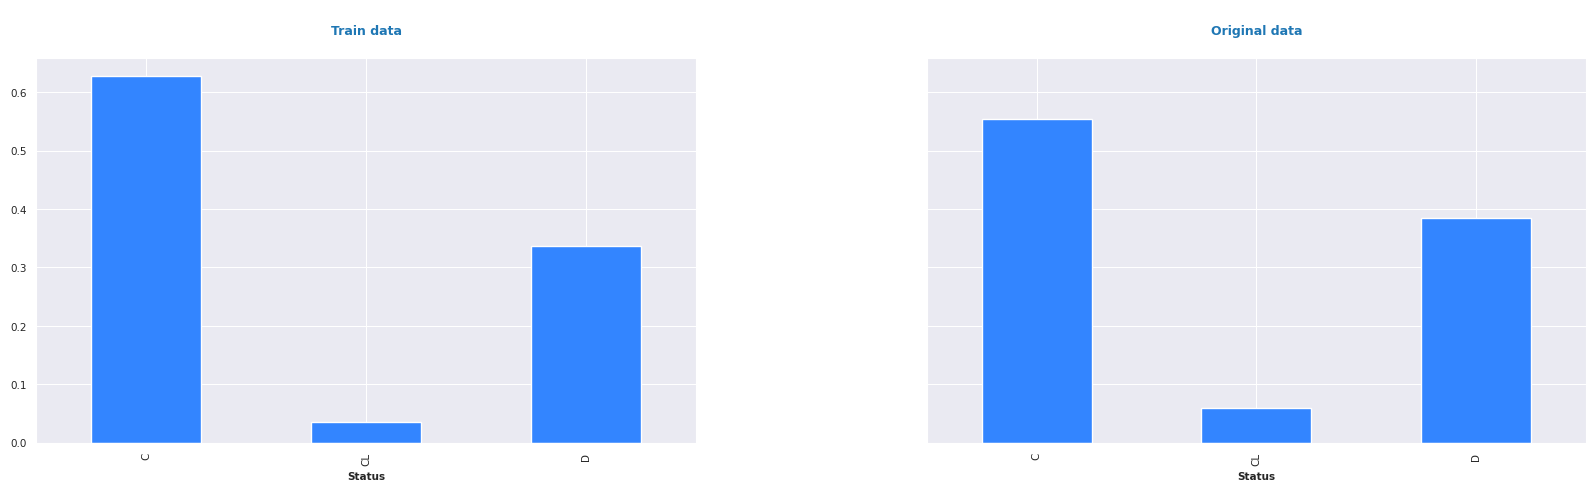


CPU times: user 780 ms, sys: 263 ms, total: 1.04 s
Wall time: 674 ms


In [11]:
%%time 

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1,2, figsize = (20, 5), sharey = True, gridspec_kw = {'wspace': 0.35});
    
    for i, df in tqdm(enumerate([pp.train, pp.original]), "Target plot ---> "):
        ax= axes[i];
        a = df[CFG.target].value_counts(normalize = True);
        a.sort_index().plot.bar(color = '#3385ff', ax = ax);
        df_name = 'Train' if i == 0 else "Original";
        _ = ax.set_title(f"\n{df_name} data\n", **CFG.title_specs);
        
    plt.tight_layout();
    plt.show();
    
print();
collect();

<a id="5.5"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONTINUOUS COLUMN PLOTS<br><div>

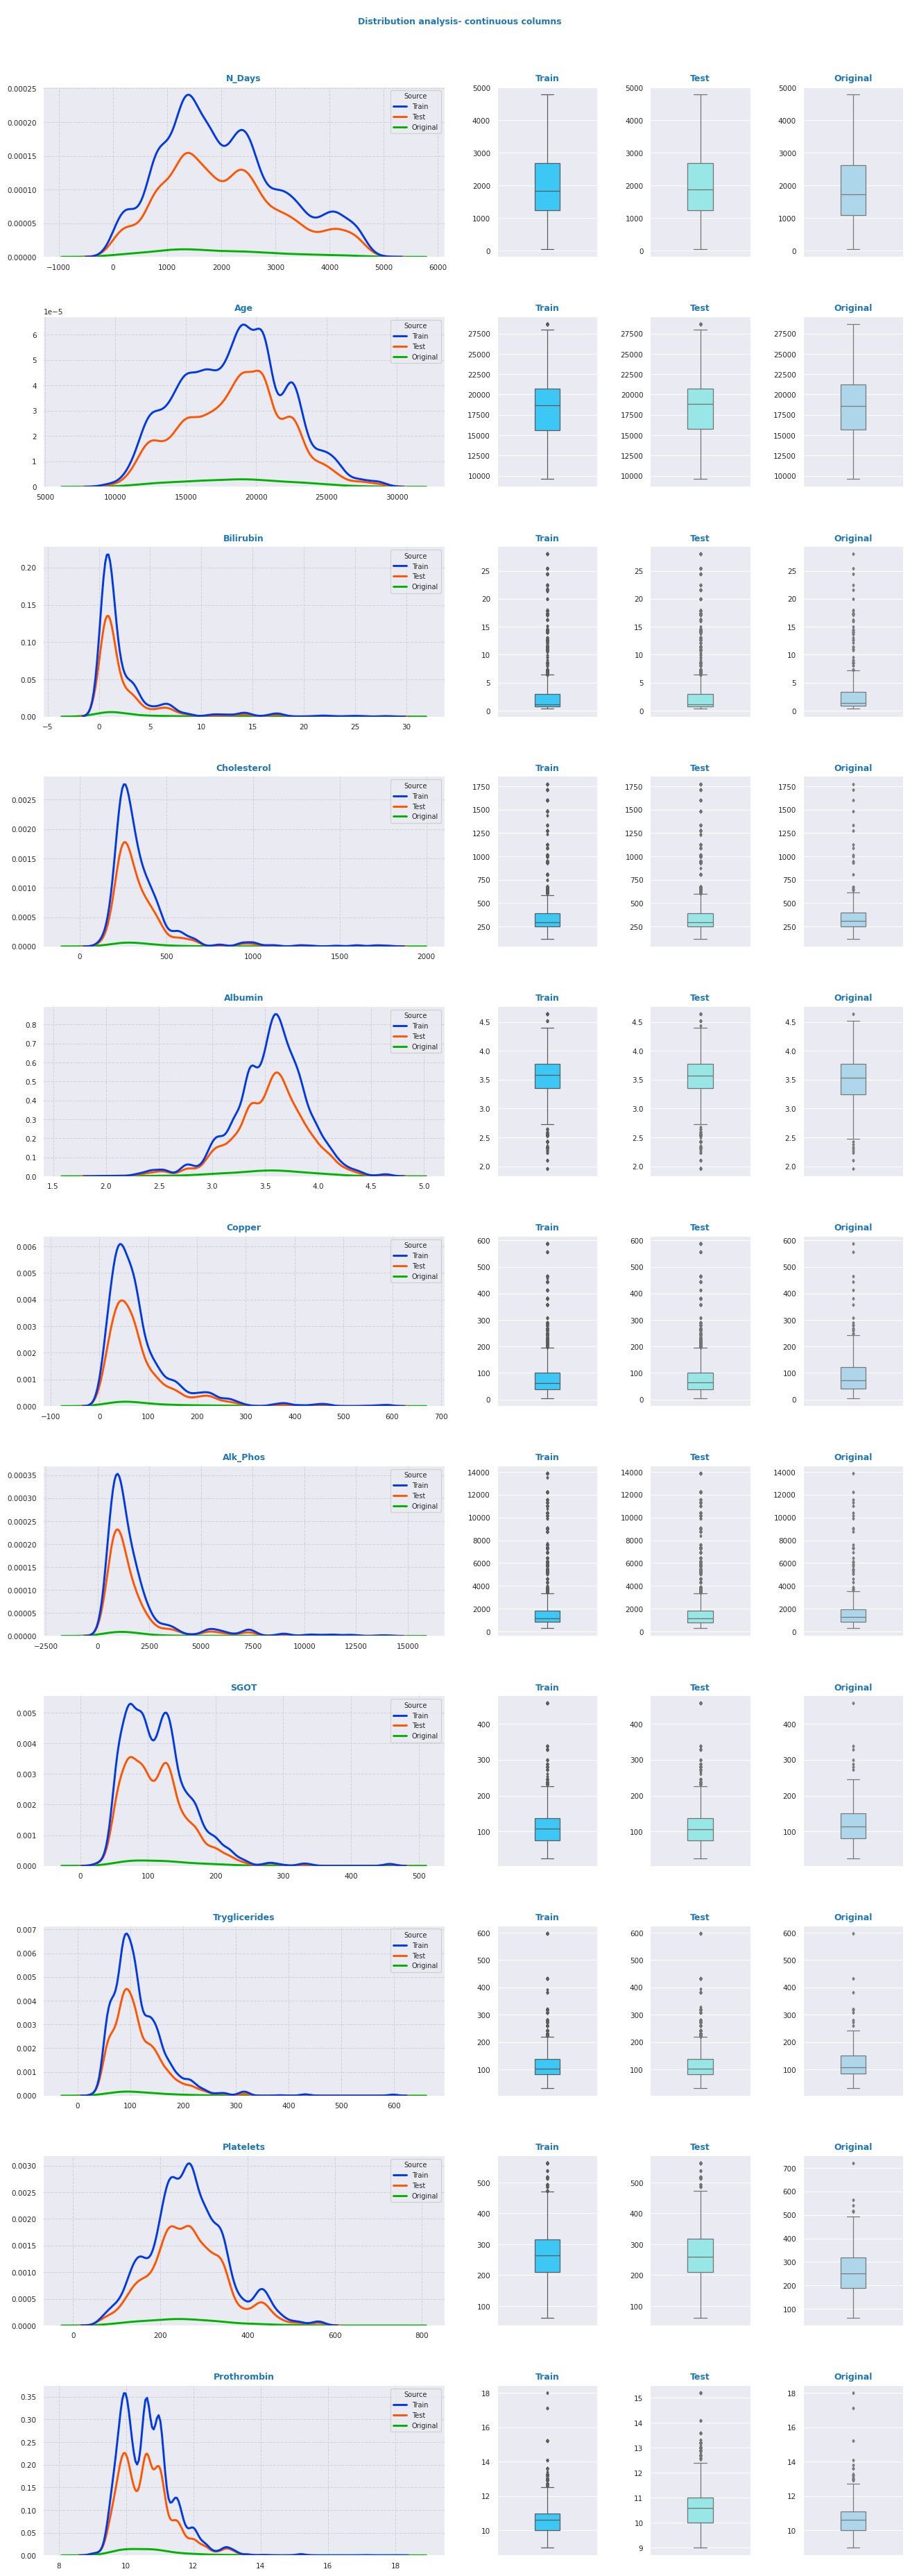


CPU times: user 9.45 s, sys: 242 ms, total: 9.69 s
Wall time: 9.43 s


In [12]:
%%time 

if CFG.ftre_plots_req == "Y":
    df = pd.concat([pp.train[cont_cols].assign(Source = 'Train'), 
                    pp.test[cont_cols].assign(Source = 'Test'),
                    pp.original[cont_cols].assign(Source = "Original")
                   ], 
                   axis=0, ignore_index = True
                  );
    
    fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20, 0.20]});
    
    for i,col in enumerate(cont_cols):
        ax = axes[i,0];
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = ['#0039e6', '#ff5500', '#00b300'], 
                    ax = ax, linewidth = 2.1
                   );
        ax.set_title(f"\n{col}", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');
        
        ax = axes[i,1];
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                    color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                    fliersize= 2.25,
                    ax = ax);
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Train", **CFG.title_specs);
        
        ax = axes[i,2];
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Test", **CFG.title_specs);
        
        ax = axes[i,3];
        sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Original", **CFG.title_specs);
              
    plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                 y = 0.905, x = 0.50
                );
    plt.tight_layout();
    plt.show();
    
print();
collect();

In [13]:
%%time 

# Calculating skewness across columns:-
skew_df = pd.DataFrame(index = cont_cols);
for col, df in {"Train": pp.train[cont_cols], 
                "Test": pp.test[cont_cols], 
                "Original": pp.original[cont_cols]}.items():   
    skew_df = \
    pd.concat([skew_df, 
               df.drop(columns = [CFG.target, "Source", "id"], errors = "ignore").skew()],
               axis=1).rename({0: col}, axis=1);

PrintColor(f"\nSkewness across independent features\n");
display(skew_df.transpose().style.format(precision = 2).background_gradient("Pastel2"));

collect();
print();


Skewness across independent features



,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin
Train,0.45,0.08,3.34,3.68,-0.56,2.70,3.20,1.53,2.63,0.42,1.29
Test,0.43,-0.02,3.42,3.67,-0.58,2.86,3.22,1.67,2.45,0.43,1.12
Original,0.47,0.09,2.72,3.41,-0.47,2.30,2.99,1.45,2.52,0.63,2.22



CPU times: user 211 ms, sys: 3.05 ms, total: 214 ms
Wall time: 211 ms


<a id="5.6"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CATEGORY COLUMN PLOTS<br><div>

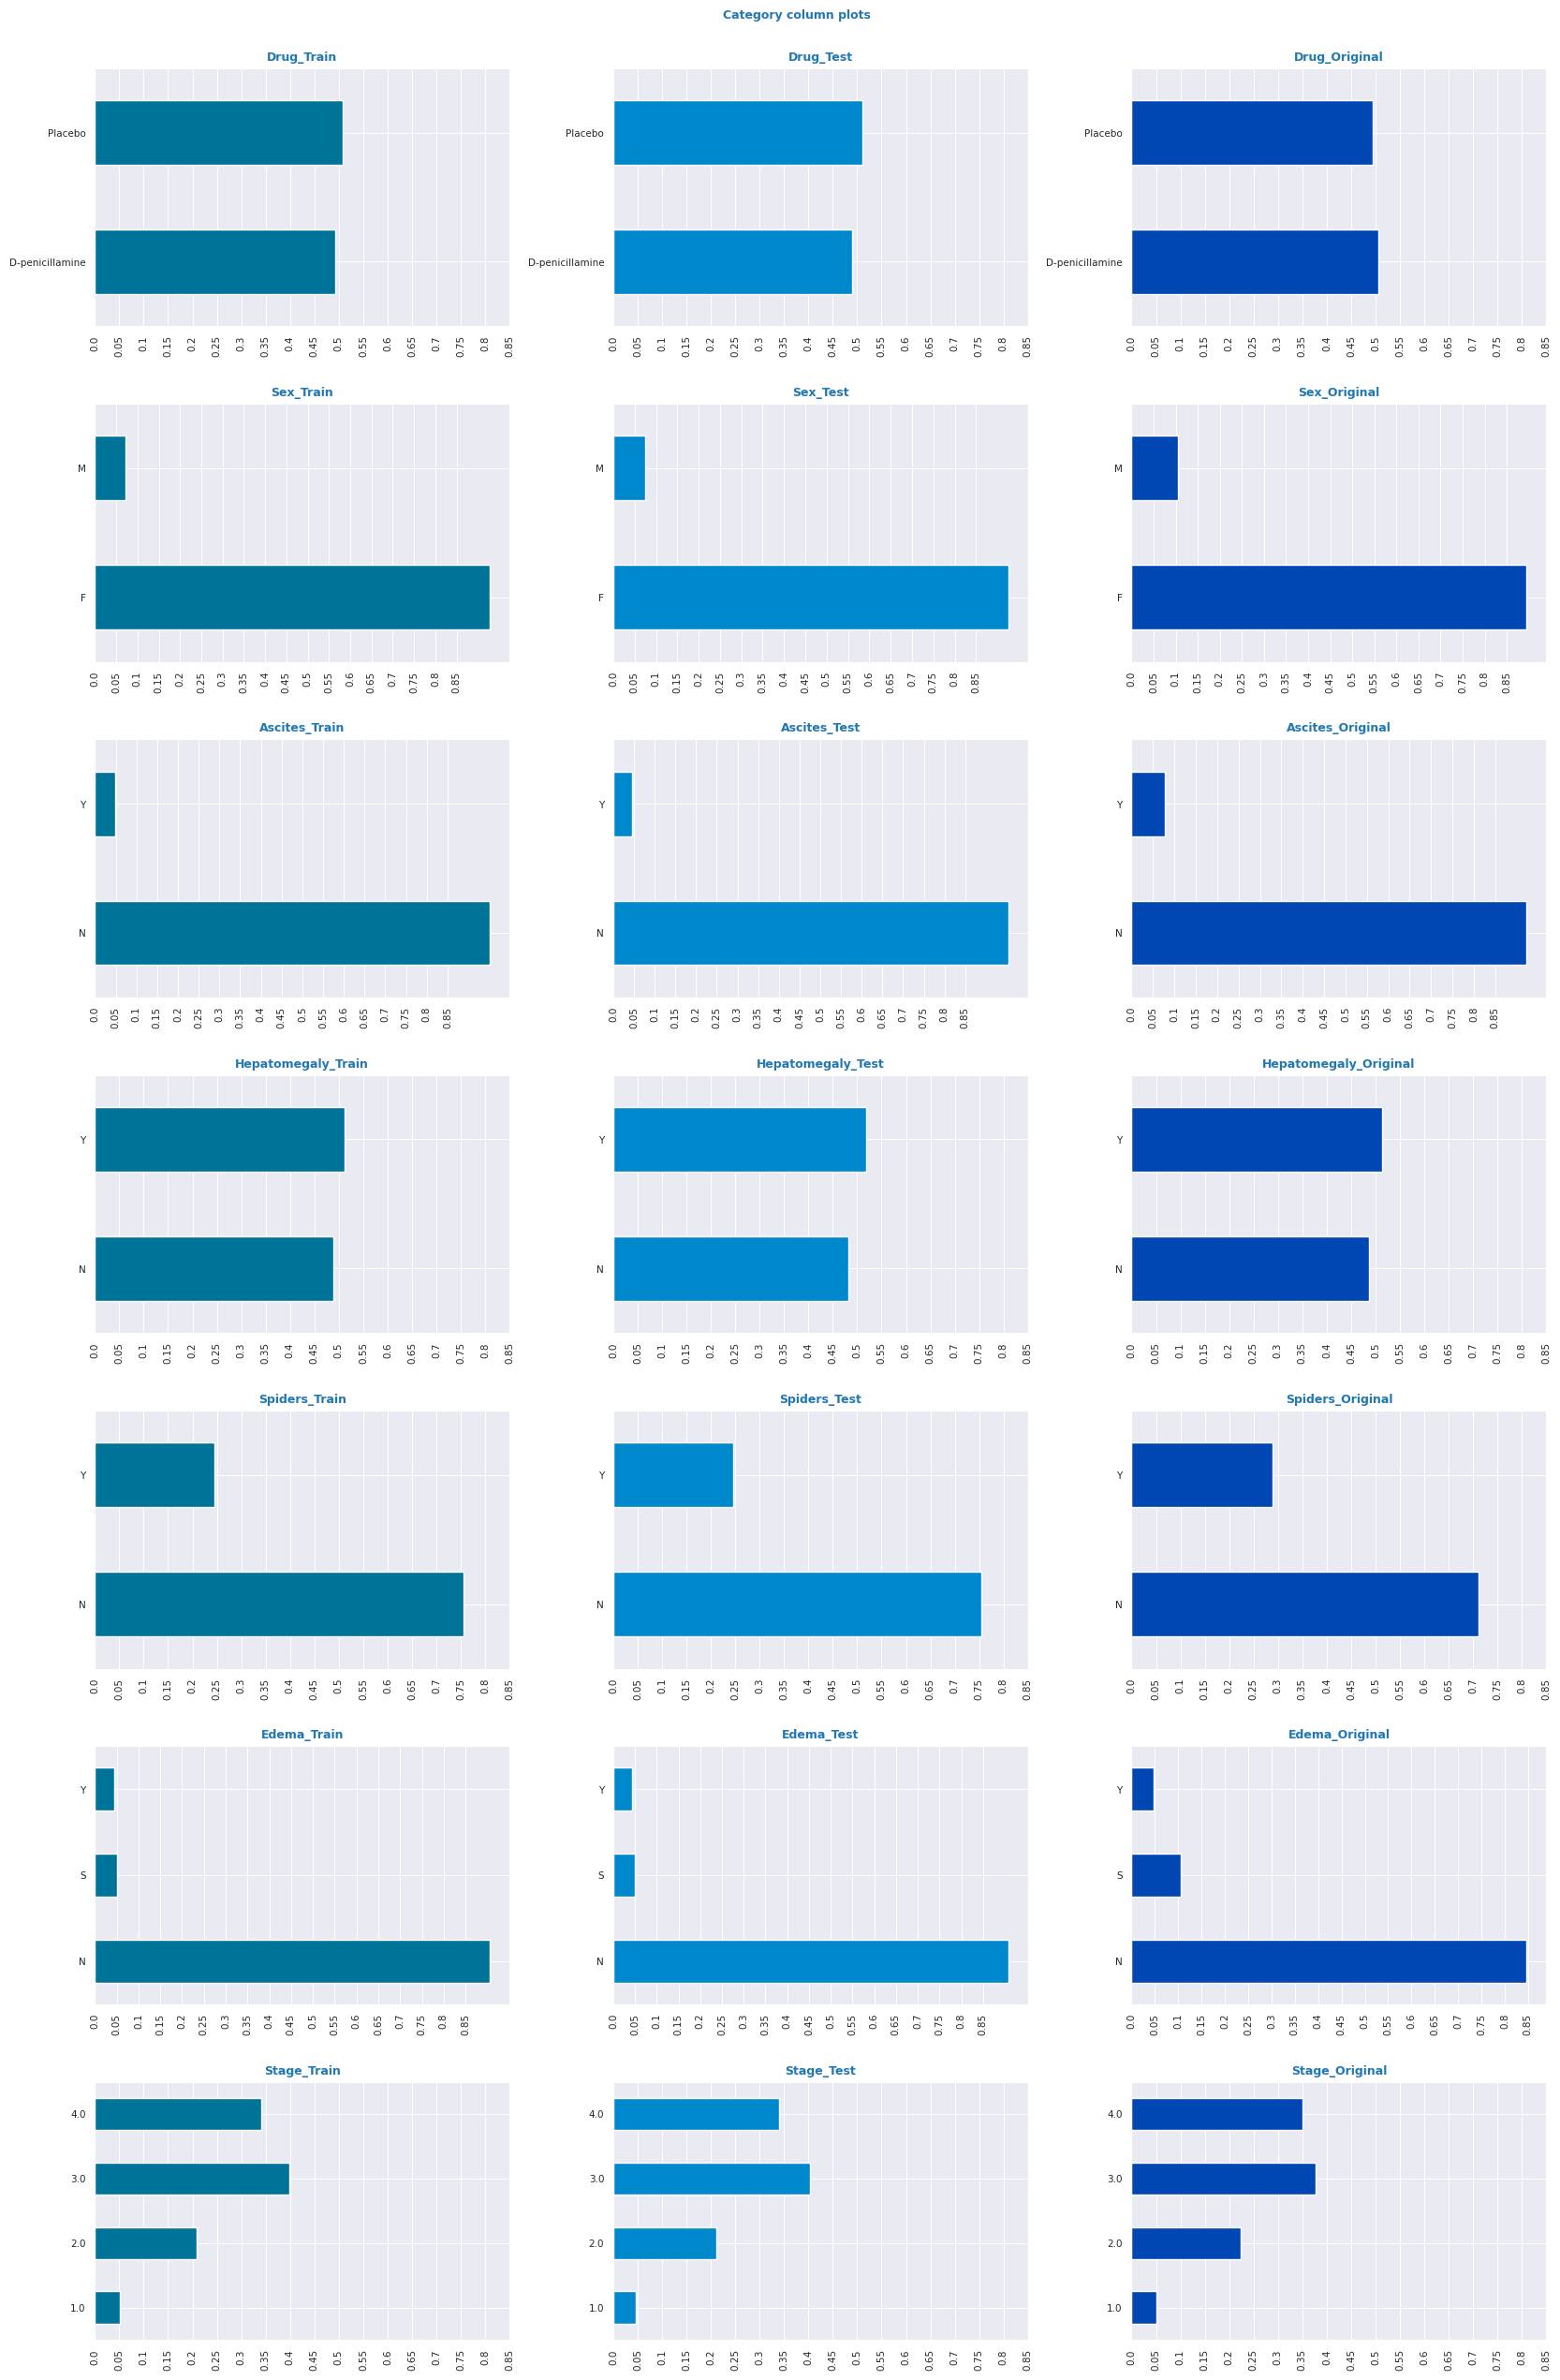


CPU times: user 6.88 s, sys: 218 ms, total: 7.1 s
Wall time: 6.82 s


In [14]:
%%time 

if CFG.ftre_plots_req == "Y" and cat_cols != []:
    fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                             gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

    for i, col in enumerate(cat_cols):
        ax = axes[i, 0];
        a = pp.train[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#007399');
        ax.set_title(f"{col}_Train", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;

        ax = axes[i, 1];
        a = pp.test[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0088cc');
        ax.set_title(f"{col}_Test", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;
        
        ax = axes[i, 2];
        a = pp.original[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0047b3');
        ax.set_title(f"{col}_Original", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;       
    
    plt.suptitle(f"Category column plots", **CFG.title_specs, y= 0.90);
    plt.tight_layout();
    plt.show();
    
print();
collect();


<a id="5.7"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > FEATURE INTERACTION AND UNIVARIATE RELATIONS<br><div>
    


In [15]:
%%time 

def MakeCorrPlot(df: pd.DataFrame, data_label:str, figsize = (30, 9)):
    """
    This function develops the correlation plots for the given dataset
    """;
    
    fig, axes = plt.subplots(1,2, figsize = figsize, gridspec_kw = {'hspace': 0.2, 'wspace': 0.1},
                             sharey = True
                            );
    
    for i, method in enumerate(['pearson', 'spearman']):
        corr_ = df.drop(columns = ['id', 'Source'], errors = 'ignore').corr(method = method);
        ax = axes[i];
        sns.heatmap(data = corr_,  
                    annot= True,
                    fmt= '.2f', 
                    cmap = 'Blues',
                    annot_kws= {'fontweight': 'bold','fontsize': 6.75}, 
                    linewidths= 1.5, 
                    linecolor='white', 
                    cbar= False, 
                    mask= np.triu(np.ones_like(corr_)),
                    ax= ax
                   );
        ax.set_title(f"\n{method.capitalize()} correlation- {data_label}\n", **CFG.title_specs);
        
    collect();
    print();

print();
collect();


CPU times: user 164 ms, sys: 0 ns, total: 164 ms
Wall time: 163 ms


<a id="5.12"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. Features are positively and negatively skewed and are all non-negative. Feature transforms may be useful for non-tree models<br>
2. Outlier treatment could be considered as an option considering outlier presence across all columns in the data<br>
3. Higher correlation between quite a few columns may necessitate methods like PCA <br>
</div>

<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > DATA TRANSFORMS <br><div> 
    
This section aims at creating secondary features, scaling and if necessary, conjoining the competition training and original data tables<br>


In [16]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        self.sec_ftre_req = CFG.sec_ftre_req;
    
    def fit(self, X, y= None, **params):
        return self;
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        It also encodes category columns manually
        """;
        
        df                 = X.copy().fillna(method = "ffill").fillna(method = "bfill"); 
        df['Age_Yr']       = df['Age']/ 365;
        df['Drug']         = np.where(df['Drug'] == "Placebo", 0,1).astype(np.uint8);
        df['Sex']          = np.where(df['Sex'] == "M", 1,0).astype(np.uint8);
        df['Ascites']      = np.where(df['Ascites'] == "N", 1,0).astype(np.uint8);
        df['Hepatomegaly'] = np.where(df['Hepatomegaly'] == "N", 1,0).astype(np.uint8);
        df['Spiders']      = np.where(df['Spiders'] == "N", 1,0).astype(np.uint8);
        df['Edema']        = df['Edema'].map({"N": 0, "S": 1, "Y": 2}).astype(np.uint8);
        df['Stage']        = df['Stage'].fillna(1).astype(np.uint8);
        df['Diseases']     = (df['Ascites'] + df['Hepatomegaly'] + df['Spiders'] + df['Edema'] + df['Drug']).astype(np.uint8);
        
        if self.sec_ftre_req == "Y":
            df['Age_Risk'] = np.where(df['Age_Yr'] >= 45, 1,0);
            df['Bilirubin_Risk'] = \
            np.select([df.Bilirubin < 1.2, df.Bilirubin < 2], [0,1],2);
            df['Cholesterol_Risk'] = \
            np.select([df.Cholesterol < 200, df.Cholesterol <= 239], [0,1], 2);
            df['Albumin_Risk'] = \
            np.select([df.Albumin.between(3.4, 5.4, inclusive = "left"),df.Albumin < 3.4], 
                      [0,1], 2
                     );
            df['Copper_Risk'] = \
            np.select([df.Copper.between(62, 140, inclusive = "left"), df.Copper < 62], 
                      [0,1], 2
                     );  
            df['Tryglicerides_Risk'] = \
            np.select([df.Tryglicerides < 150, df.Tryglicerides < 200, df.Tryglicerides < 499], 
                      [0,1,2], 3
                     );
            df['Platelets_Risk'] = \
            np.select([df.Platelets.between(150, 450, inclusive = "left"),df.Platelets < 150], 
                      [0,1], 2
                     );            
            df['Prothrombin_Risk'] = \
            np.select([df.Prothrombin.between(11,13.5, inclusive = "left"),df.Prothrombin < 11], 
                      [0,1], 2
                     );              
        
        self.op_cols = df.columns;
        df = self._reduce_mem(df);
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 165 ms, sys: 73 µs, total: 165 ms
Wall time: 164 ms


In [17]:
%%time

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

ytrain = train[CFG.target];
Xtrain = train.drop(columns = [CFG.target]);
Xtest  = test.copy(deep = True);

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

print();
xform  = Pipeline(steps = [("S1", Xformer())]);                    
Xtrain = xform.fit_transform(Xtrain, ytrain);
Xtest  = xform.transform(Xtest);
print();

PrintColor(f"\n---> Train data columns after data pipeline\n");
pprint(Xtrain.columns);

PrintColor(f"\n---> Test data columns after data pipeline\n");
pprint(Xtest.columns);
PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");

PrintColor(f"\n---> Dropping duplicates in the train data");
_ = pd.concat([Xtrain, ytrain], axis=1).drop_duplicates(subset = Xtrain.columns[0:-1].to_list());
_.index = range(len(_));
Xtrain, ytrain = _.drop(columns = [CFG.target]), _[CFG.target];
del _;
PrintColor(f"---> Train-test shape after duplicate removal = {Xtrain.shape} {Xtest.shape}");

print();
collect();



==================== Data transformation ==================== 


---> Train data



,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Source
id,,,,,,,,,,,,,,,,,,,
0,999,D-penicillamine,21532,M,N,N,N,N,2.30,316.00,3.35,172.00,1601.00,179.80,63.00,394.00,9.70,3.00,Competition
1,2574,Placebo,19237,F,N,N,N,N,0.90,364.00,3.54,63.00,1440.00,134.85,88.00,361.00,11.00,3.00,Competition
2,3428,Placebo,13727,F,N,Y,Y,Y,3.30,299.00,3.55,131.00,1029.00,119.35,50.00,199.00,11.70,4.00,Competition
3,2576,Placebo,18460,F,N,N,N,N,0.60,256.00,3.50,58.00,1653.00,71.30,96.00,269.00,10.70,3.00,Competition
4,788,Placebo,16658,F,N,Y,N,N,1.10,346.00,3.65,63.00,1181.00,125.55,96.00,298.00,10.60,4.00,Competition



---> Test data



,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Source
id,,,,,,,,,,,,,,,,,,,
7905,3839,D-penicillamine,19724,F,N,Y,N,N,1.20,546.00,3.37,65.00,1636.00,151.90,90.00,430.00,10.60,2.00,Competition
7906,2468,D-penicillamine,14975,F,N,N,N,N,1.10,660.00,4.22,94.00,1257.00,151.90,155.00,227.00,10.00,2.00,Competition
7907,51,Placebo,13149,F,N,Y,N,Y,2.00,151.00,2.96,46.00,961.00,69.75,101.00,213.00,13.00,4.00,Competition
7908,2330,D-penicillamine,20510,F,N,N,N,N,0.60,293.00,3.85,40.00,554.00,125.55,56.00,270.00,10.60,2.00,Competition
7909,1615,D-penicillamine,21904,F,N,Y,N,N,1.40,277.00,2.97,121.00,1110.00,125.00,126.00,221.00,9.80,1.00,Competition



Start - end memory:-  0.89 -  0.48 Mb
Start - end memory:-  0.60 -  0.34 Mb


---> Train data columns after data pipeline

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Source',
       'Age_Yr', 'Diseases'],
      dtype='object')

---> Test data columns after data pipeline

Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Source',
       'Age_Yr', 'Diseases'],
      dtype='object')

---> Train-test shape after pipeline = (8323, 21) (5271, 21)

---> Dropping duplicates in the train data
---> Train-test shape after duplicate removal = (8323, 21) (5271, 21)

CPU times: user 279 ms, sys: 5.74 ms, total: 285 ms
Wall time: 286 ms


In [18]:
%%time 

# Shortlisting the duplicate data between train and test dataframes for post-processing:-
join_cols = Xtrain.columns[0:-1].to_list();

dups_df = \
Xtrain.\
reset_index(names = "id").\
assign(Label = "Train").\
merge(Xtest.reset_index().assign(Label = "Test"),
      how = "inner", on = join_cols, suffixes = ("_train", "_test")).\
drop(columns = join_cols).\
merge(ytrain, how = "inner", left_on = "id_train", right_index = True)\
[['id_train', 'id_test', CFG.target]].\
drop_duplicates(subset = ['id_test']);

del join_cols;

PrintColor(f"\n---> Train-test duplicate data glimpse- shape = {dups_df.shape}");
display(dups_df.head(10).style.format(precision = 3));
dups_df.to_csv(f"Duplicates.csv", index = None);

collect();
print();


---> Train-test duplicate data glimpse- shape = (0, 3)


,id_train,id_test,Status



CPU times: user 187 ms, sys: 1.99 ms, total: 189 ms
Wall time: 189 ms




CPU times: user 1.2 s, sys: 184 ms, total: 1.39 s
Wall time: 1.12 s


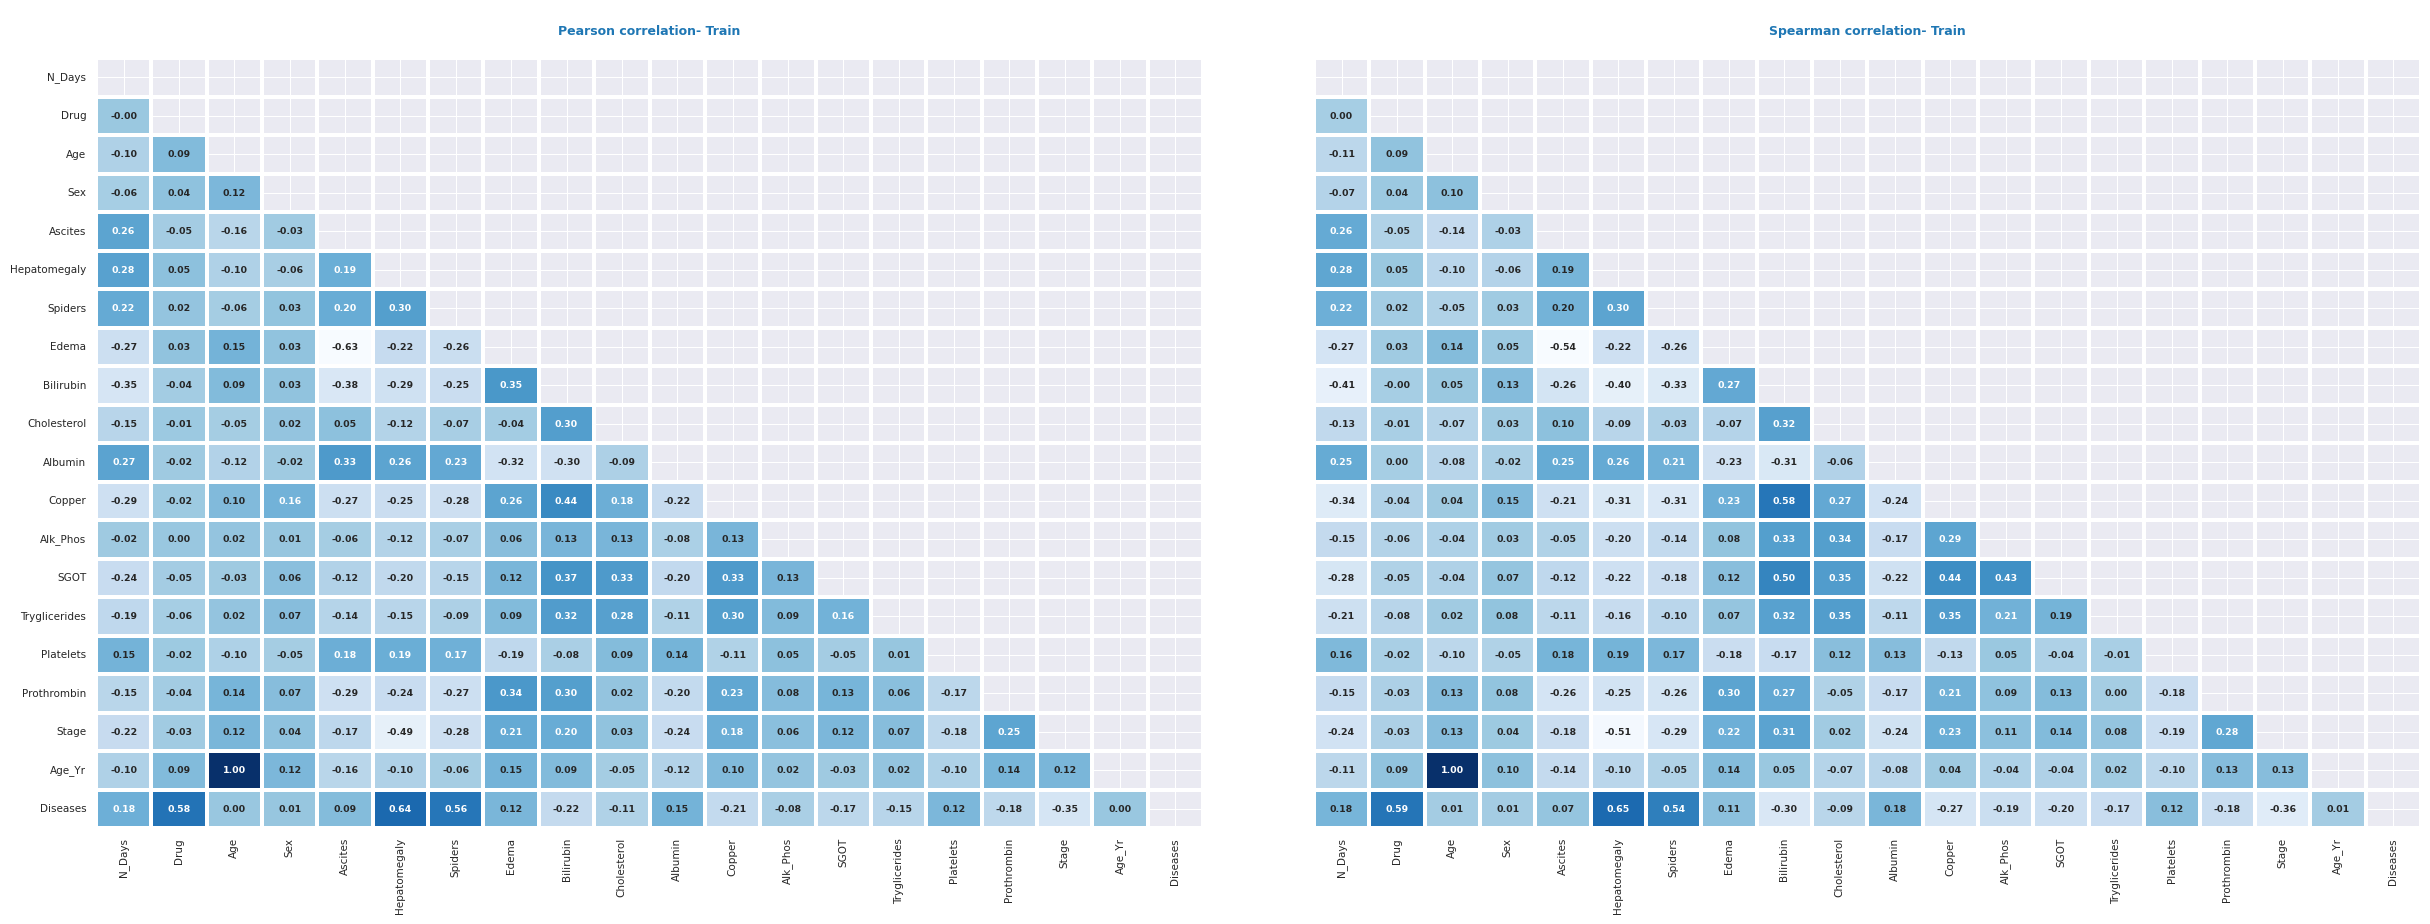

In [19]:
%%time 

# Implementing correlation analysis:-
if CFG.ftre_imp_req == "Y":
    MakeCorrPlot(df = Xtrain, data_label = "Train", figsize = (30,10));
    
print();
collect();

<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > MODEL TRAINING <br><div> 
   

In [20]:
%%time 

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the OOF and Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(self, Xtrain, ytrain, Xtest, sel_cols, cat_cols, **kwarg):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        """;
        
        self.Xtrain      = Xtrain;
        self.Ytrain      = ytrain;
        self.Xtest       = Xtest;
        self.sel_cols    = sel_cols;
        self.cat_cols    = cat_cols;

        self.tgt_cat     = CFG.tgt_mapper;
        self.tgt_cat_inv = {i:j for j, i in CFG.tgt_mapper.items()};
        self.nclass      = len(CFG.tgt_mapper.keys());
        self.ytrain      = self.Ytrain.map(self.tgt_cat).astype(np.uint8);
        
        self._DefineModels();
        self.cv        = self.all_cv[CFG.mdlcv_mthd];
        self.methods   = list(self.Mdl_Master.keys());
        self.OOF_Preds = pd.DataFrame(columns = [f"Status_{k}" for k in self.tgt_cat.keys()]);
        self.Mdl_Preds = pd.DataFrame(index = self.Xtest.index, columns = [f"Status_{k}" for k in self.tgt_cat.keys()]);
        self.Scores    = pd.DataFrame(columns = self.methods, index = range(CFG.n_splits * CFG.n_repeats));
        
        self.mdlscorer = make_scorer(self.ScoreMetric, 
                                     greater_is_better = False,
                                     needs_proba       = True,
                                     needs_threshold   = False,
                                    );  
        self.y_grp = self.ytrain;

        PrintColor(f"\n---> Selected model options-");
        pprint(self.methods, depth = 1, width = 100, indent = 5);
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state),
         'RKF' : RKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'RSKF': RSKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'SKF' : SKF(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state)
        };
               
        self.Mdl_Master = \
        {                      
         'XGB1C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.035,
                          'max_depth'             : 8,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 12,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),
            
         'XGB2C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.40,
                          'learning_rate'         : 0.02,
                          'max_depth'             : 9,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.12,
                          'reg_lambda'            : 0.8,
                          'min_child_weight'      : 15,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),

         'XGB3C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'multi:softprob',
                          'eval_metric'           : "mlogloss",
                          'num_class'             : self.nclass,
                          'random_state'          : CFG.state,
                          'colsample_bytree'      : 0.5,
                          'learning_rate'         : 0.04,
                          'max_depth'             : 8,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.2,
                          'reg_lambda'            : 0.6,
                          'min_child_weight'      : 16,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                         }
                      ),
              
         'LGBM1C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.025,
                           'max_depth'           : 8,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 100,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
         'LGBM2C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.20,
                           'subsample'           : 0.25,
                           'learning_rate'       : 0.018,
                           'max_depth'           : 9,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 85, 
                           'reg_alpha'           : 0.15,
                           'reg_lambda'          : 0.90,
                           'verbosity'           : -1,
                           'categorical_feature' : [f"name: {col}" for col in self.cat_cols],
                          }
                       ),
            
         'LGBM3C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.45,
                           'subsample'           : 0.45,
                           'learning_rate'       : 0.03,
                           'max_depth'           : 7,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 100, 
                           'reg_alpha'           : 0.2,
                           'reg_lambda'          : 0.6,
                           'verbosity'           : -1,
                          }
                       ), 
            
         'LGBM4C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'multiclass',
                           'num_class'           : self.nclass,
                           'boosting_type'       : 'gbdt',
                           'random_state'        : CFG.state,
                           'colsample_bytree'    : 0.185,
                           'subsample'           : 0.55,
                           'learning_rate'       : 0.04,
                           'max_depth'           : 9,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 76, 
                           'reg_alpha'           : 0.08,
                           'reg_lambda'          : 0.995,
                           'verbosity'           : -1,
                          }
                       ),
        };
        return self;
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return log_loss(ytrue, ypred);
    
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        """;
        return ypred;
    
    def TrainMdl(self, test_preds_req: str = "Y"):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        """;

        # Initializing I-O:- 
        X,y, Xt    = self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols];
        cols_drop  = ['Source', "id"];

        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
            Xdev = X.iloc[dev_idx].loc[X.Source == "Competition"].drop(columns = cols_drop, errors = 'ignore'); 
            
            ytr  = y.loc[y.index.isin(Xtr.index)];
            ydev = y.loc[y.index.isin(Xdev.index)];
            
            if CFG.test_req == "Y":
                print(f"---> {Xtr.shape} {Xdev.shape} {ytr.shape} {ydev.shape} {Xt.shape}");
            else:
                pass;
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n");
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]); 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                              M__cat_features = self.cat_cols
                             ); 

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                             verbose = False,),
                                             ],
                             ); 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              );            

                else: 
                    model.fit(Xtr, ytr);

                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds   = model.predict_proba(Xdev);
                train_preds = model.predict_proba(Xtr);
            
                if test_preds_req == "Y": 
                    test_preds = model.predict_proba(Xt.drop(columns = cols_drop, errors = "ignore"));
                    self.Mdl_Preds = \
                    pd.concat([self.Mdl_Preds,
                               pd.DataFrame(index = self.Xtest.index,data = test_preds, 
                                            columns = self.Mdl_Preds.columns
                                           )
                              ],axis=0, ignore_index= False
                             );
                    del test_preds;
            
                tr_score = self.ScoreMetric(ytr.values.flatten(),train_preds);
                score    = self.ScoreMetric(ydev.values.flatten(),dev_preds);
                
                num_space = 3 if fold_nb <= 9 else 2;
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f} | {method}",
                           color = Fore.CYAN
                          );
                del num_space;

                self.Scores.loc[fold_nb, method] = np.round(score, decimals= 6);
                self.OOF_Preds = \
                pd.concat([self.OOF_Preds,
                           pd.DataFrame(index = Xdev.index,data = dev_preds,columns = self.OOF_Preds.columns)
                          ],axis=0, ignore_index= False
                         ); 

        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean();
        if test_preds_req == "Y": 
            self.Mdl_Preds = self.Mdl_Preds.groupby(level = 0).mean();
            
        return self.OOF_Preds, self.Mdl_Preds, self.Scores;
         
    def DisplayScores(self):
        "This method displays the scores and their means";
        
        print("\n\n");
        display(self.Scores.style.format(precision = 5).\
                background_gradient(cmap = "icefire", subset = self.methods).\
                set_caption(f"\nOOF scores across methods and folds\n")
               );
        
        print();
        display(self.Scores.mean().to_frame().\
                transpose().style.format(precision = 5).\
                background_gradient(cmap = "Pastel2", subset = self.methods, axis=1).\
                set_caption(f"\nMean CV scores across folds\n")
               );
        
        PrintColor(f"\n---> Mean score across all methods and folds = {np.mean(np.ravel(Scores)):.5f}\n",
                   color = Fore.LIGHTMAGENTA_EX
                  );
        collect();
        
    
print();
collect();


CPU times: user 175 ms, sys: 1.97 ms, total: 177 ms
Wall time: 176 ms


In [21]:
%%time 

if CFG.ML == "Y":
    # Training the models with a CV analysis:-
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns");
    with np.printoptions(linewidth = 150):
        print(sel_cols);
        
    PrintColor(f"\n---> Selected categorical columns");  
    cat_ftre = [c for c in sel_cols if c in cat_cols or c.endswith("Risk")];
    with np.printoptions(linewidth = 150):
        print(np.array(cat_ftre));

    print();
    collect();
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV {'=' * 20}\n", color = Fore.MAGENTA);
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores = md.TrainMdl(test_preds_req = "Y");
    md.DisplayScores();
    collect();
    
print();
collect();



---> Selected model columns
Index(['N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders',
       'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos',
       'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'Source',
       'Age_Yr', 'Diseases'],
      dtype='object')

---> Selected categorical columns
['Drug' 'Sex' 'Ascites' 'Hepatomegaly' 'Spiders' 'Edema' 'Stage']


==================== ML MODELS TRAINING AND CV ====================


---> Selected model options-
['XGB1C', 'XGB2C', 'XGB3C', 'LGBM1C', 'LGBM2C', 'LGBM3C', 'LGBM4C']


0it [00:00, ?it/s]


===== FOLD 1 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.40732 | Train = 0.22988 | XGB1C
OOF = 0.40909 | Train = 0.23304 | XGB2C
OOF = 0.41112 | Train = 0.23071 | XGB3C
OOF = 0.41695 | Train = 0.23611 | LGBM1C
OOF = 0.40947 | Train = 0.24905 | LGBM2C
OOF = 0.41486 | Train = 0.23979 | LGBM3C
OOF = 0.41425 | Train = 0.20049 | LGBM4C

===== FOLD 2 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.41119 | Train = 0.22560 | XGB1C
OOF = 0.41499 | Train = 0.25504 | XGB2C
OOF = 0.41838 | Train = 0.27344 | XGB3C
OOF = 0.42640 | Train = 0.19793 | LGBM1C
OOF = 0.41626 | Train = 0.23533 | LGBM2C
OOF = 0.42359 | Train = 0.20518 | LGBM3C
OOF = 0.41731 | Train = 0.22712 | LGBM4C

===== FOLD 3 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.43435 | Train = 0.22617 | XGB1C
OOF = 0.44068 | Train = 0.22900 | XGB2C
OOF = 0.44427 | Train = 0.25127 | XGB3C
OOF = 0.45225 | Train = 0.25079 | LGBM1C
OOF = 0.43784 | Train = 0.24574 | LGBM2C
OOF = 0.44536 | Train = 0.24522 | LGBM3C
OOF = 0.43666 | Train = 0.22274 | LGBM4C

===== FOLD 4 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.43178 | Train = 0.24367 | XGB1C
OOF = 0.44116 | Train = 0.24324 | XGB2C
OOF = 0.44352 | Train = 0.27991 | XGB3C
OOF = 0.44541 | Train = 0.22352 | LGBM1C
OOF = 0.42606 | Train = 0.24398 | LGBM2C
OOF = 0.44066 | Train = 0.22124 | LGBM3C
OOF = 0.42786 | Train = 0.22786 | LGBM4C

===== FOLD 5 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.40851 | Train = 0.21961 | XGB1C
OOF = 0.41073 | Train = 0.24143 | XGB2C
OOF = 0.41811 | Train = 0.25870 | XGB3C
OOF = 0.41553 | Train = 0.19999 | LGBM1C
OOF = 0.40100 | Train = 0.23154 | LGBM2C
OOF = 0.41163 | Train = 0.22546 | LGBM3C
OOF = 0.40785 | Train = 0.18233 | LGBM4C

===== FOLD 6 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.41688 | Train = 0.22320 | XGB1C
OOF = 0.41474 | Train = 0.23027 | XGB2C
OOF = 0.41463 | Train = 0.22203 | XGB3C
OOF = 0.42299 | Train = 0.20384 | LGBM1C
OOF = 0.41980 | Train = 0.22695 | LGBM2C
OOF = 0.41985 | Train = 0.22497 | LGBM3C
OOF = 0.42011 | Train = 0.19117 | LGBM4C

===== FOLD 7 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.44970 | Train = 0.26012 | XGB1C
OOF = 0.44880 | Train = 0.24300 | XGB2C
OOF = 0.44767 | Train = 0.27387 | XGB3C
OOF = 0.45172 | Train = 0.23185 | LGBM1C
OOF = 0.45404 | Train = 0.26329 | LGBM2C
OOF = 0.45208 | Train = 0.25709 | LGBM3C
OOF = 0.45470 | Train = 0.23461 | LGBM4C

===== FOLD 8 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.43452 | Train = 0.22797 | XGB1C
OOF = 0.44584 | Train = 0.24434 | XGB2C
OOF = 0.45077 | Train = 0.23619 | XGB3C
OOF = 0.45824 | Train = 0.22037 | LGBM1C
OOF = 0.43129 | Train = 0.23837 | LGBM2C
OOF = 0.45108 | Train = 0.22181 | LGBM3C
OOF = 0.43181 | Train = 0.20303 | LGBM4C

===== FOLD 9 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.42242 | Train = 0.21436 | XGB1C
OOF = 0.42579 | Train = 0.23056 | XGB2C
OOF = 0.42749 | Train = 0.25433 | XGB3C
OOF = 0.43135 | Train = 0.19071 | LGBM1C
OOF = 0.42226 | Train = 0.23594 | LGBM2C
OOF = 0.42634 | Train = 0.20750 | LGBM3C
OOF = 0.42572 | Train = 0.20549 | LGBM4C

===== FOLD 10 =====



  0%|          | 0/7 [00:00<?, ?it/s]

OOF = 0.44126 | Train = 0.24702 | XGB1C
OOF = 0.44289 | Train = 0.23894 | XGB2C
OOF = 0.44583 | Train = 0.24913 | XGB3C
OOF = 0.45559 | Train = 0.22445 | LGBM1C
OOF = 0.44619 | Train = 0.26020 | LGBM2C
OOF = 0.45473 | Train = 0.25831 | LGBM3C
OOF = 0.44753 | Train = 0.20950 | LGBM4C





,XGB1C,XGB2C,XGB3C,LGBM1C,LGBM2C,LGBM3C,LGBM4C
0,0.40732,0.40909,0.41112,0.41695,0.40947,0.41486,0.41425
1,0.41119,0.41499,0.41838,0.42640,0.41626,0.42359,0.41731
2,0.43434,0.44068,0.44427,0.45225,0.43784,0.44536,0.43666
3,0.43178,0.44116,0.44352,0.44541,0.42606,0.44066,0.42786
4,0.40851,0.41073,0.41811,0.41553,0.40100,0.41163,0.40785
5,0.41688,0.41474,0.41463,0.42299,0.41980,0.41985,0.42011
6,0.44970,0.44879,0.44767,0.45172,0.45404,0.45208,0.45470
7,0.43452,0.44584,0.45077,0.45824,0.43129,0.45108,0.43181
8,0.42242,0.42579,0.42749,0.43135,0.42226,0.42634,0.42572
9,0.44126,0.44289,0.44583,0.45559,0.44619,0.45473,0.44754


,XGB1C,XGB2C,XGB3C,LGBM1C,LGBM2C,LGBM3C,LGBM4C
0,0.42579,0.42947,0.43218,0.43764,0.42642,0.43402,0.42838



---> Mean score across all methods and folds = 0.43056


CPU times: user 8min 14s, sys: 11.4 s, total: 8min 25s
Wall time: 3min 1s


In [22]:
%%time 

# Saving the datasets:-
if CFG.ML == "Y":
    sub_fl = Mdl_Preds.reset_index();
    sub_fl.to_csv(f"Submission_V{CFG.version_nb}.csv", index = None);
    OOF_Preds.to_csv(f"OOF_Preds_V{CFG.version_nb}.csv");
    Mdl_Preds.to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv");
    
    PrintColor(f"\nFinal submission file\n");
    display(sub_fl.head(10).style.format(precision = 3));
    
collect();
print(); 


Final submission file



,id,Status_C,Status_CL,Status_D
0,7905,0.528,0.022,0.450
1,7906,0.624,0.197,0.179
2,7907,0.040,0.016,0.944
3,7908,0.963,0.005,0.033
4,7909,0.867,0.030,0.102
5,7910,0.991,0.001,0.007
6,7911,0.970,0.004,0.027
7,7912,0.174,0.021,0.805
8,7913,0.008,0.002,0.990
9,7914,0.634,0.018,0.347



CPU times: user 308 ms, sys: 4.94 ms, total: 313 ms
Wall time: 311 ms


<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > NEXT STEPS <br><div> 
   

1. We will perform a detailed EDA and elicit feature interactions and other relevant insights
2. Model tuning
3. Including other models in the ensemble
4. Better ensemble strategy
5. Any other discussion/ public work based insights